# This notebook will build the model for predicting the price of properties. 
## 1. First basic model based on multiple linear regression.
### 1. import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.clean_data import run_cleanup
from src.clean_data import split_df_on_type
from src.linear_model import model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### 2. Read the csv-file and put it into a pandas DataFrame

print(df_house.head())
print(df_apt.head())

In [4]:
file_path = '../Data/house_details_v1.csv'
df = pd.read_csv(file_path, index_col='id', skip_blank_lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1   Housenumber        19963 non-null  object 
 2   Box                19963 non-null  object 
 3   Floor              19963 non-null  float64
 4   City               19963 non-null  object 
 5   Postalcode         19963 non-null  object 
 6   Type               19963 non-null  object 
 7   Subtype            19963 non-null  object 
 8   Location area      19963 non-null  object 
 9   Region             19963 non-null  object 
 10  District           19963 non-null  object 
 11  Province           19963 non-null  object 
 12  Price              19963 non-null  float64
 13  Type of sale       19963 non-null  object 
 14  Construction year  19963 non-null  float64
 15  Total surface      19963 non-null  float64
 16  Habitable surface

### 3. Clean data via clean_data.py:

In [22]:
drop_columns=[
            'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location area', 'Region', 
            'District', 'Province', 'Type of sale', 'Garden', 'Kitchen type', 'EPC score', 'Latitude',
            'Longitude', 'Property url'
            ]

#trans_columns= ['Region', 'Province', 'Terrace', '']

df, df_house, df_apt = run_cleanup(df)

<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1   Housenumber        19963 non-null  object 
 2   Box                19963 non-null  object 
 3   Floor              19963 non-null  float64
 4   City               19963 non-null  object 
 5   Postalcode         19963 non-null  float64
 6   Type               19963 non-null  object 
 7   Subtype            19963 non-null  object 
 8   Location area      19963 non-null  object 
 9   Region             19963 non-null  object 
 10  District           19963 non-null  object 
 11  Province           19963 non-null  object 
 12  Price              19963 non-null  float64
 13  Type of sale       19963 non-null  object 
 14  Construction year  19963 non-null  float64
 15  Total surface      19963 non-null  float64
 16  Habitable surface

#### 3.1 Check for features with too strong correlation (= more than 0.70)

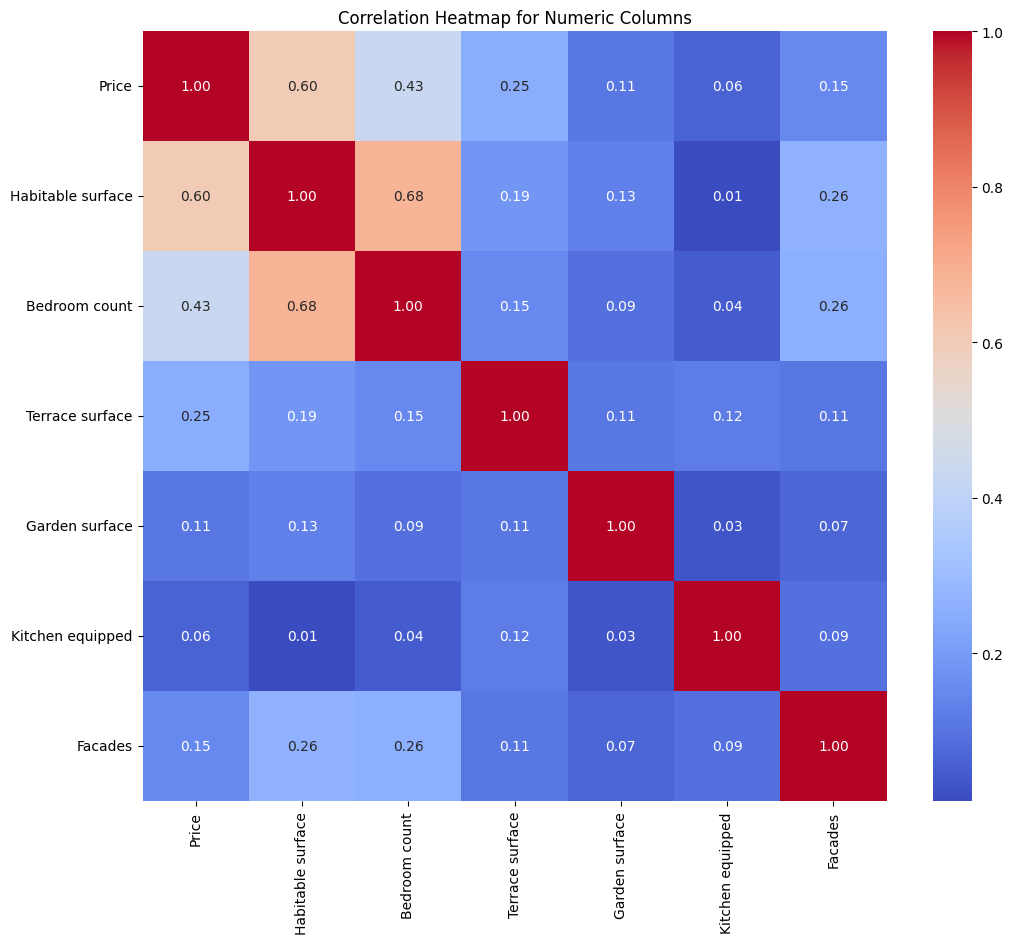

In [23]:
house_columns = ['Price', 'Habitable surface', 'Bedroom count', 'Terrace surface', 'Garden surface', 'Kitchen equipped', 'Facades']
#numeric_df = df.select_dtypes(include=[float, int])
numeric_df = df[house_columns]
# Compute the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Add a title to the heatmap
plt.title("Correlation Heatmap for Numeric Columns")

# Show the plot
plt.show()

### 4. First pipeline on the DataFrame:

In [24]:
df_columns = ['Habitable surface', 'Bedroom count', 'Postalcode', 'Terrace surface', 'Garden surface', 'Kitchen equipped', 'Construction year', 'Total surface', 'Garden surface', 'Facades']
X= df[df_columns].to_numpy()
y = df.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)

0.41760059515845005
107593187093.48335


Model running for house listings only

In [25]:
house_columns = ['Habitable surface', 'Bedroom count', 'Postalcode', 'Terrace surface', 'Garden surface', 'Kitchen equipped', 'Facades']
X = df_house[house_columns].to_numpy()
y = df_house.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)

0.4880836987848677
133122544977.77768


Model for apartment listings only

In [26]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equipped', 'Floor']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)


0.3699017991652733
292565692893.04175


### 5. Try a non-linear model: XGboost

In [52]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equipped', 'Floor', 'Postalcode']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Initialize and train the XGBoost regression model
xgb_model = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
xgb_model.fit(X_train, y_train)

# Evaluate the model on training and testing data
print("Training R-squared score:", xgb_model.score(X_train, y_train))
print("Testing R-squared score:", xgb_model.score(X_test, y_test))

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print("Mean Squared Error:", mse)

# Perform cross-validation and compute mean and standard deviation of R-squared scores
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)

fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color='blue', size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")
# Calculate the absolute difference between the price and the predicted price
absolute_difference = abs(y_test.flatten() - y_pred)

# Create a list to store the colors for the dots based on the condition
dot_colors = ['green' if diff < 0.1 * price else 'blue' for price, diff in zip(y_test.flatten(), absolute_difference)]

# Create an interactive scatter plot of actual prices vs. predicted prices
fig = go.Figure()

# Add actual prices and predicted prices as scatter plot traces with custom colors
fig.add_trace(go.Scattergl(x=y_test.flatten(),
                           y=y_pred,
                           mode='markers',
                           marker=dict(color=dot_colors, size=8),
                           name='Predicted vs. Actual Prices',
                           text=[f'Data Point Index: {i}' for i in np.arange(len(y_test))],
                           hoverinfo='text+x+y'))

# Add a 1:1 line (y=x) to indicate perfect predictions
diagonal_line = go.Scatter(x=[min(y_test.flatten()), max(y_test.flatten())],
                           y=[min(y_test.flatten()), max(y_test.flatten())],
                           mode='lines',
                           line=dict(color='red', dash='solid'),
                           name='Perfect Prediction')

fig.add_trace(diagonal_line)

# Update layout
fig.update_layout(title='Actual vs. Predicted Prices (Test Data)',
                  xaxis_title='Actual Price',
                  yaxis_title='Predicted Price',
                  showlegend=True,
                  hovermode='closest'
                 )

# Show the interactive plot
fig.show()

# Save the plot as an interactive HTML file in the "output" folder
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file_path = os.path.join(output_folder, 'xgboost_actual_vs_predicted_scatterplot_green.html')
fig.write_html(output_file_path)

print(f"Interactive scatter plot saved as an HTML at: {output_file_path}")

Training R-squared score: 0.9760689132378142
Testing R-squared score: 0.7953724751828277
Mean Squared Error: 30181359493.786747
Cross-validation R2 scores: [0.781147   0.7513715  0.76094237 0.8177008  0.74827572]
Mean cross-validation R2 score: 0.7718874765567308
Standard deviation of cross-validation R2 scores: 0.02562348382449125


Interactive scatter plot saved as an HTML at: output\xgboost_actual_vs_predicted_scatterplot.html


Interactive scatter plot saved as an HTML at: output\xgboost_actual_vs_predicted_scatterplot_green.html


In [32]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equipped', 'Floor']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1 , 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
regressor = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
regressor.fit(X_train, y_train)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
y_pred = regressor.predict(X_test)
score = regressor.score(X_test, y_test)  # Use X_test and y_test for scoring
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
print(df.shape)
print(X.shape)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

0.8542600688274283
0.4359413134358987
Cross-validation R2 scores: [0.4653863  0.36062663 0.27417838 0.48893632 0.29600483]
Mean cross-validation R2 score: 0.37702649451842746
Standard deviation of cross-validation R2 scores: 0.08688206419952893
(10655, 17)
(4751, 5)


### 6. Try the complete pipeline, running the model function from linear_model.py
#### 1. Df chosen = 2 (df_house), Model 1 is XGboost()

In [39]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=1, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

The score for the model is: 0.8139794139600395
The MSE for this model is 33405017389.98944
Cross-validation R2 scores: [0.78778462 0.76218229 0.77674445 0.76220889 0.77573358]
Mean cross-validation R2 score: 0.7729307673851449
Standard deviation of cross-validation R2 scores: 0.009731653832767955


#### 2. Model 2 is LinearRegression()

In [38]:
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(1, model=2, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_pred, mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=y_test.flatten(), y=y_test.flatten(), mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

The score for the model is: 0.4008520491584987
The MSE for this model is 107593187093.48335
Cross-validation R2 scores: [0.4378235  0.41528181 0.35800803 0.40579361 0.43607575]
Mean cross-validation R2 score: 0.41059653950882985
Standard deviation of cross-validation R2 scores: 0.0289864404504597


In [ ]:
from src.clean_data import run_cleanup
from src.linear_model import model
from src.linear_model import get_model_input
from src.linear_model import get_scaled_input
from src.linear_model import get_df_input
# Get user input for model_number
while True:
    model_input = input("Choose the model (1 for Linear Regression, 2 for XGBoost): ")
    if model_input.isdigit():
        model_number = int(model_input)
        if model_number in [1, 2]:
            break
    print("Invalid input. Please enter 1 or 2.")

# Get user input for scaled
while True:
    scale_input = input("Do you want to scale the data? (y/n): ")
    if scale_input.lower() in ['y', 'n']:
        scaled = True if scale_input.lower() == 'y' else False
        break
    print("Invalid input. Please enter 'y' or 'n'.")

# Get user input for DataFrame choice
while True:
    df_input = input("Choose the DataFrame (1 for entire DataFrame, 2 for houses, 3 for apartments): ")
    if df_input.isdigit():
        df_choice = int(df_input)
        if df_choice in [1, 2, 3]:
            break
    print("Invalid input. Please enter 1, 2, or 3.")

# Get user inputs for model, scaling, and DataFrame choice
model_number = get_model_input()
scaled = get_scaled_input()
df_choice = get_df_input()

regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(df_choice,model=model_number, scaled=scaled )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig.show()